# Training U-Net
-- Chang (Chris) Qian

## Load packages

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py


from tensorflow import keras
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, CSVLogger
from keras.initializers import *


os.listdir('.')

['AFM data 1.h5',
 'AFM data 2.h5',
 'Inspection U-Net.ipynb',
 'tf gpu env.txt',
 'Training set+validation set.h5',
 'Traning U-Net.ipynb',
 'U-Net model_20230923_002.hdf5']

In [2]:
def addDimension(m):
    temp = np.zeros([m.shape[0],m.shape[1],1])
    temp = np.concatenate((m,temp), axis=2)
    return temp


In [3]:
dataset_path = 'Training set+validation set.h5'
model_path = 'U-Net model_20240312.hdf5'

num_train = 500
num_val = 20

## Load data

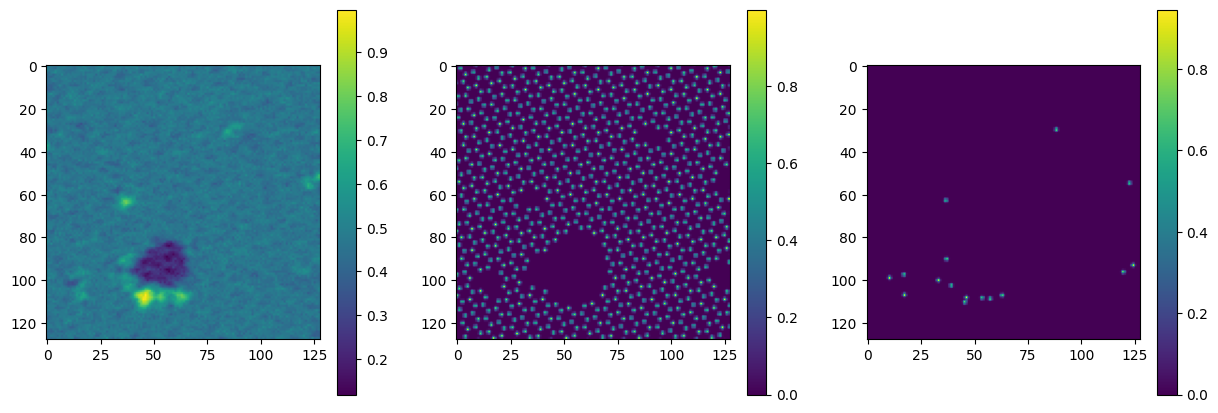

In [4]:
with h5py.File(dataset_path, 'r') as file:
    image_stack = file['/data'][:]
    
image_stack = np.moveaxis(image_stack,1, 3)
image_stack = np.swapaxes(image_stack, 1, 2)
image_stack = np.flip(image_stack, axis=1)

fig, ax = plt.subplots(1,3,figsize=(15,5))
i1 = ax[0].imshow(image_stack[0,:,:,2].clip(0,1))
i2 = ax[1].imshow(image_stack[0,:,:,0])
i3 = ax[2].imshow(image_stack[0,:,:,1])
plt.colorbar(i1, ax=ax[0])
plt.colorbar(i2, ax=ax[1])
plt.colorbar(i3, ax=ax[2])

In [5]:
label_temp = np.random.permutation(num_train+num_val)
train_label = label_temp[0:num_train]
val_label = label_temp[num_train:num_train+num_val]

# print(train_label.shape)
# print(val_label.shape)

imgs_train = image_stack[train_label,:,:,2].clip(0,1)
imgs_train = np.expand_dims(imgs_train, axis=3)
labels_train = image_stack[train_label,:,:,0:2]
imgs_val = image_stack[val_label,:,:,2].clip(0,1)
imgs_val = np.expand_dims(imgs_val, axis=3)
labels_val = image_stack[val_label,:,:,0:2]

print(imgs_train.shape)
print(labels_train.shape)
print(imgs_val.shape)
print(labels_val.shape)

(500, 128, 128, 1)
(500, 128, 128, 2)
(20, 128, 128, 1)
(20, 128, 128, 2)


## Initialize U-Net and start training

In [6]:
def get_unet():
    inputs = Input((128, 128, 1))
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    # print ("conv1 shape:",conv1.shape)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    # print ("conv1 shape:",conv1.shape)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # print ("pool1 shape:",pool1.shape)

    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    # print ("conv2 shape:",conv2.shape)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    # print ("conv2 shape:",conv2.shape)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # print ("pool2 shape:",pool2.shape)

    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    # print ("conv3 shape:",conv3.shape)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    # print ("conv3 shape:",conv3.shape)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # print ("pool3 shape:",pool3.shape)

    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6],axis=3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)

    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv91 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv91)
    conv91 = Conv2D(9, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv91)

    conv92 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv92 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv92)
    conv92 = Conv2D(9, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv92)

    merge10 = concatenate([conv91,conv92], axis = 3)
    conv10 = Conv2D(2, 1, activation = 'linear')(merge10)

    model = Model(inputs = inputs, outputs = conv10)
    model.compile(optimizer = keras.optimizers.Adam(lr = 1e-4), loss = 'mean_squared_error', metrics = ['accuracy'])
    return model

model = get_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

D:\Anaconda3\envs\tf-gpu\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [7]:
model_checkpoint = ModelCheckpoint(model_path, monitor='loss',verbose=1, save_best_only=True)
csv_logger = CSVLogger('log.csv', append=False, separator=',')

print('Fitting model...')
model.fit(imgs_train, labels_train, batch_size=10, epochs=100, verbose=1,validation_split=0.1, shuffle=True, callbacks=[model_checkpoint,csv_logger])

Fitting model...
Epoch 1/100
45/45 [==============================] - 10s 95ms/step - loss: 0.0353 - accuracy: 0.8048 - val_loss: 0.0169 - val_accuracy: 0.9183

Epoch 00001: loss improved from inf to 0.03535, saving model to U-Net model_20240312.hdf5
Epoch 2/100
45/45 [==============================] - 4s 95ms/step - loss: 0.0166 - accuracy: 0.9167 - val_loss: 0.0161 - val_accuracy: 0.9145

Epoch 00002: loss improved from 0.03535 to 0.01662, saving model to U-Net model_20240312.hdf5
Epoch 3/100
45/45 [==============================] - 4s 91ms/step - loss: 0.0158 - accuracy: 0.9103 - val_loss: 0.0155 - val_accuracy: 0.9131

Epoch 00003: loss improved from 0.01662 to 0.01584, saving model to U-Net model_20240312.hdf5
Epoch 4/100
45/45 [==============================] - 4s 94ms/step - loss: 0.0152 - accuracy: 0.8958 - val_loss: 0.0150 - val_accuracy: 0.9203

Epoch 00004: loss improved from 0.01584 to 0.01517, saving model to U-Net model_20240312.hdf5
Epoch 5/100
45/45 [===================

## Prediction on validation set

In [8]:
predictions_val = model.predict(imgs_val, batch_size=1, verbose=1)

20/20 [==============================] - 1s 8ms/step


In [9]:
predictions_val.shape

(20, 128, 128, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'ground truth')

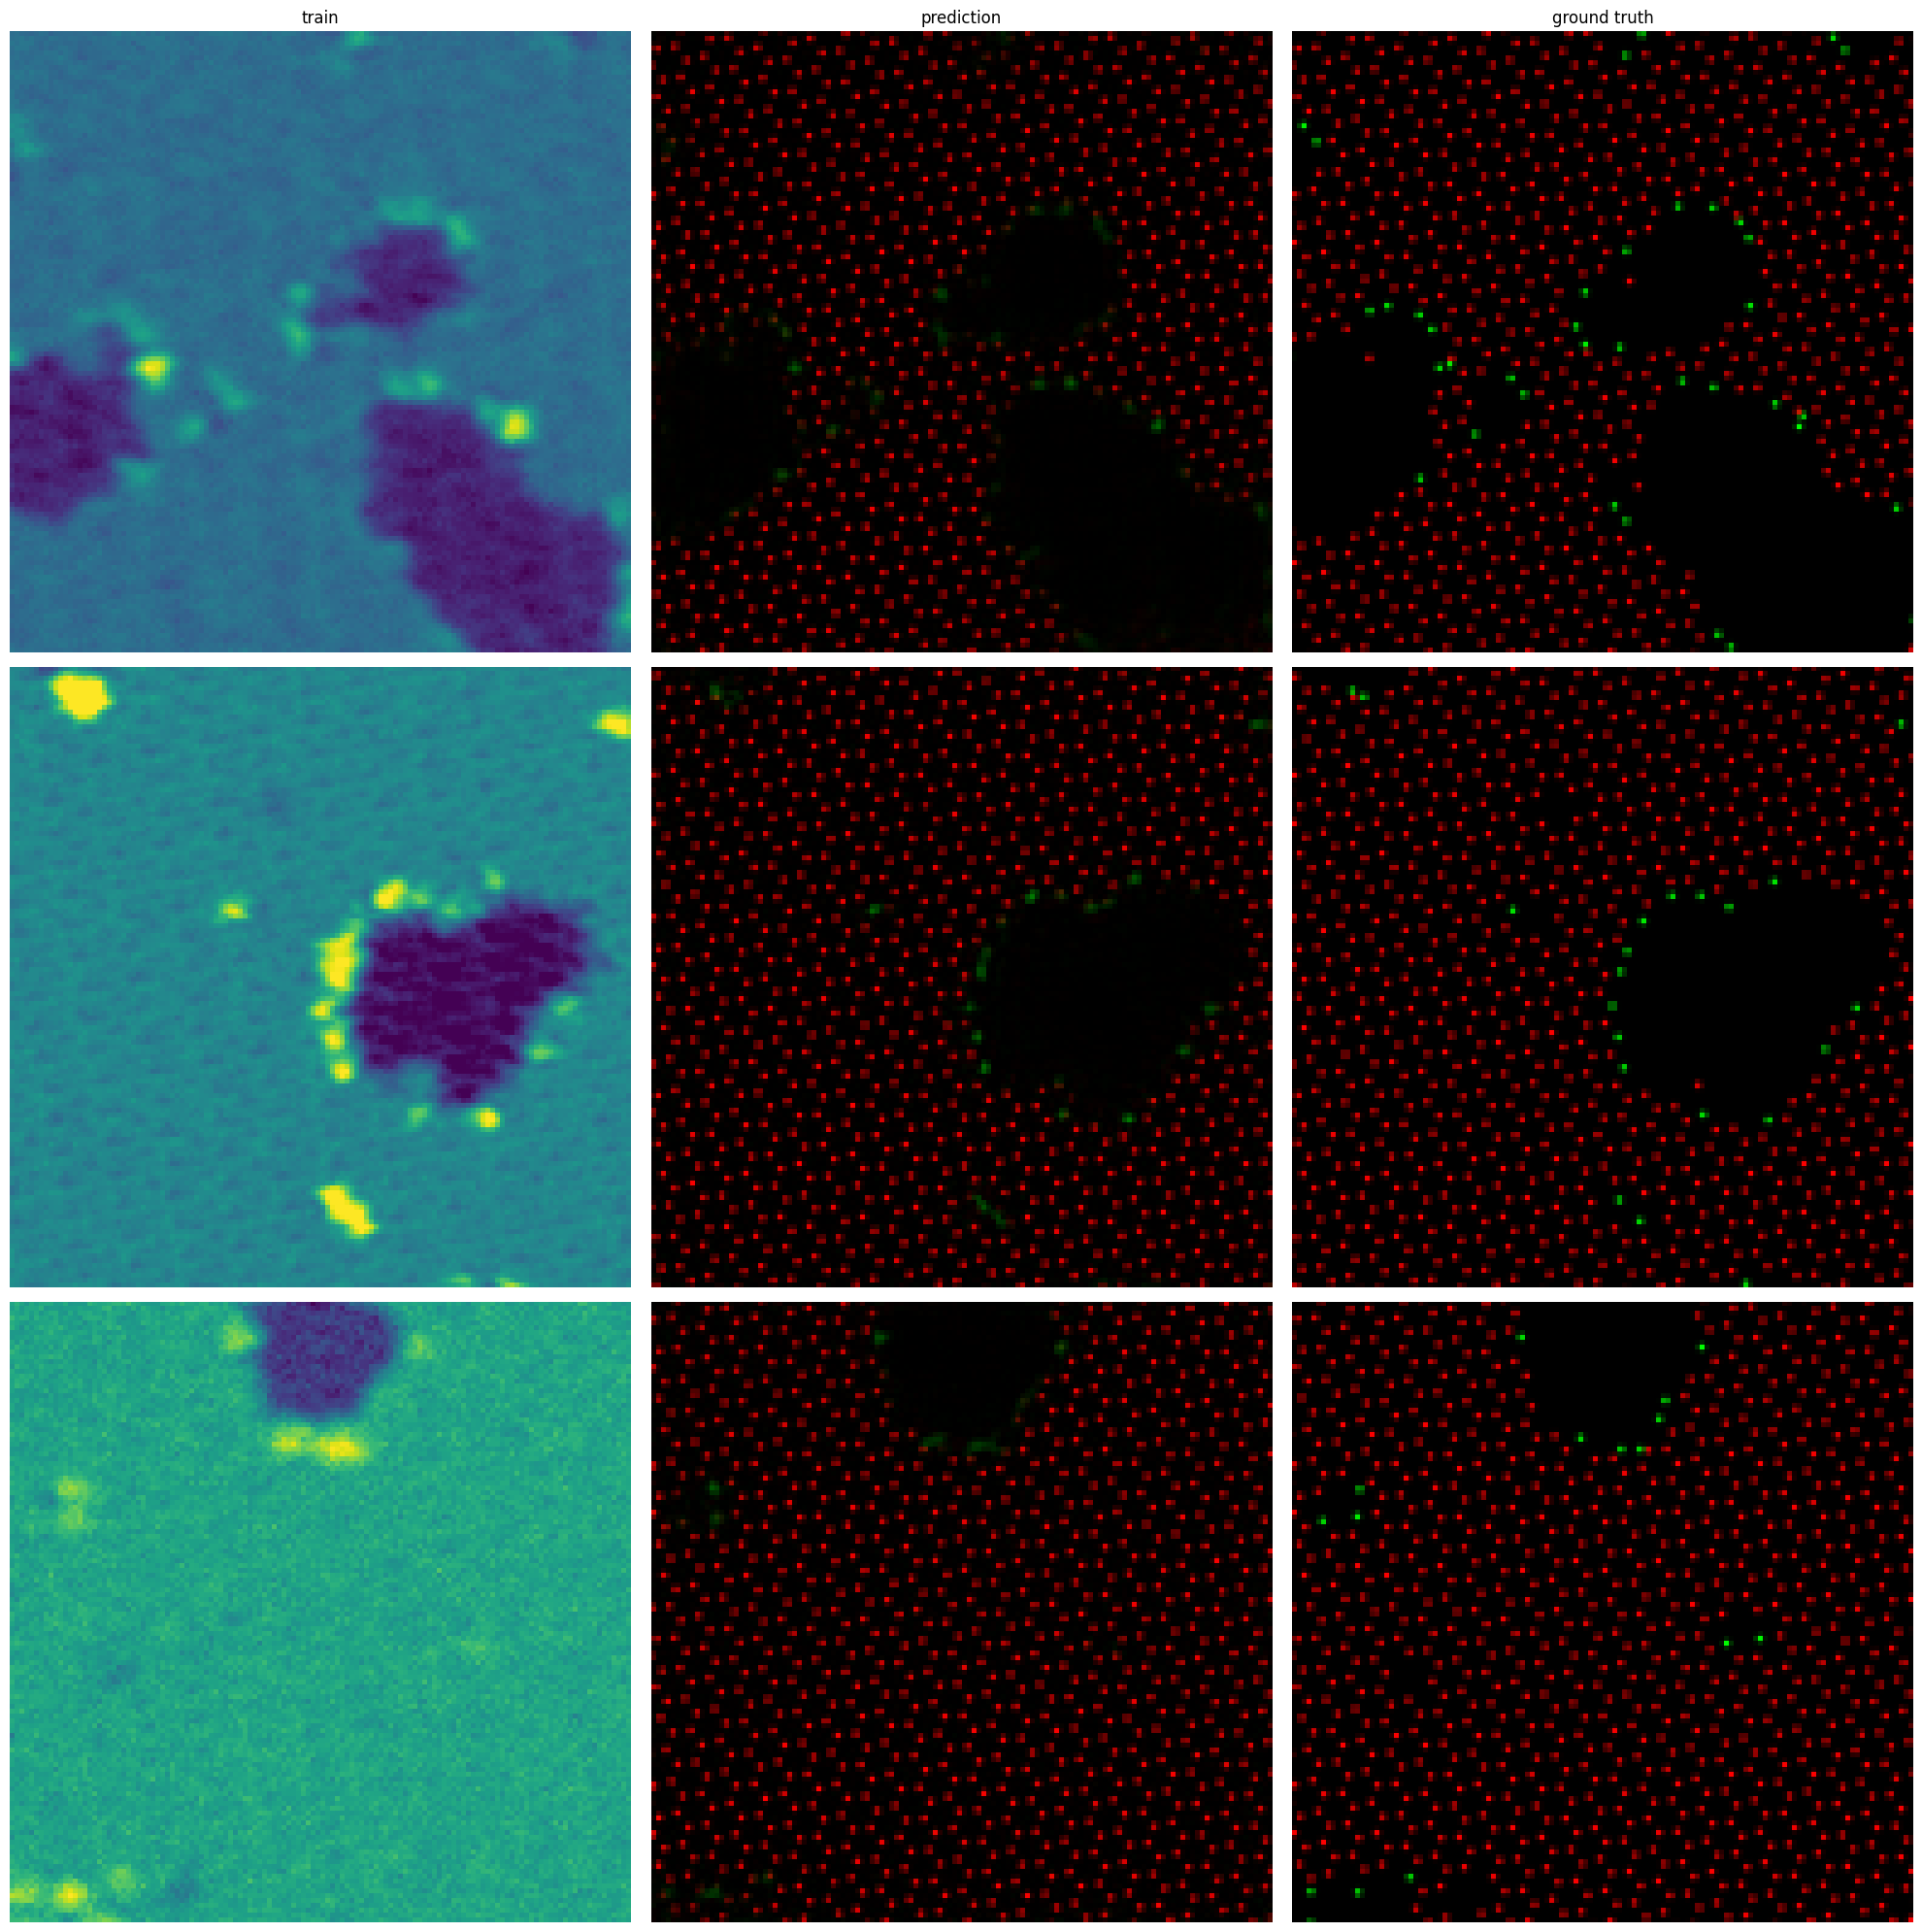

In [11]:
num_plot = 3
inds = np.random.permutation(imgs_val.shape[0])

fig, axs = plt.subplots(num_plot,3,figsize=(20,20/3*num_plot))
fig.set_tight_layout(True)

for idx in range(num_plot):
    i = inds[idx]
    axs[idx,0].imshow(imgs_val[i])
    axs[idx,1].imshow(addDimension(predictions_val[i]))
    axs[idx,2].imshow(addDimension(labels_val[i]))
    axs[idx,0].axis('off')
    axs[idx,1].axis('off')
    axs[idx,2].axis('off')
    
axs[0,0].set_title('train')
axs[0,1].set_title('prediction')
axs[0,2].set_title('ground truth')

In [14]:
output_path = 'prediction_validation_20240312.h5'
temp = np.concatenate((imgs_val,predictions_val), axis=3)

import h5py
import numpy as np
with h5py.File(output_path, 'w') as file:
    file.create_dataset('data', data=temp)

temp.shape

(20, 128, 128, 3)